<a href="https://colab.research.google.com/github/JheanmarcoOscanoa/Laboratorio---13/blob/main/Laboratorio_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 13: AJUSTE DE HIPERPARÁMETROS DE UN MODELO. ESTRATEGIAS DE COMPARACIÓN Y EVALUACIÓN DE DIFERENTES MODELOS

**Autor:** Jheanmarco Oscanoa Vargas  
**Curso:** Minería de Datos  
**Institución:** TECSUP  
**Semana:** 13

---


**CONTEXTO DEL PROYECTO**

Este dataset representa información de rendimiento de equipos en una fábrica de confecciones. Dado que el negocio depende del cumplimiento de metas diarias, y se desea anticipar si un equipo alcanzará una productividad adecuada (≥0.5), el problema es tratado como clasificación binaria.

El dataset contiene tanto datos operativos cuantitativos (como horas extras, incentivos, número de trabajadores) como atributos cualitativos (día, trimestre, departamento).

La variable objetivo actual_productivity ha sido transformada en label:
label = 1 si productividad ≥ 0.5, 0 si < 0.5.

El objetivo del modelo es ayudar a la toma de decisiones preventivas, como ajustes en incentivos o asignación de recursos.

### BLOQUE A

In [92]:
def cargar_y_preprocesar_datos(path_csv: str):
    """
    A.1 - A.7: Función para preprocesar datos del dataset de productividad de trabajadores en la industria textil.
    """
    import pandas as pd
    from sklearn.preprocessing import StandardScaler

    # A.1 Leer datos
    df = pd.read_csv(path_csv)

    # A.2 Eliminar columna 'date'
    df.drop(columns=['date'], inplace=True)

    # A.3 Crear variable binaria 'label'
    df['label'] = df['actual_productivity'].apply(lambda x: 1 if x >= 0.5 else 0)

    # A.4 Eliminar columna original de productividad
    df.drop(columns=['actual_productivity'], inplace=True)

    # A.5 Imputar valores nulos solo en variables numéricas
    df.fillna(df.mean(numeric_only=True), inplace=True)

    # A.6 Convertir categóricas a variables dummy (quarter, department, day)
    df = pd.get_dummies(df, columns=['quarter', 'department', 'day'], drop_first=True)

    # A.7 Escalar variables numéricas
    X = df.drop('label', axis=1)
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    y = df['label']
    return X_scaled, y


In [93]:
# Direccion
url = "/content/drive/MyDrive/A Ciclo 05/Mineria de Datos/Semana 13/garments_worker_productivity.csv"

X_scaled, y = cargar_y_preprocesar_datos(url)


In [94]:
# b.0 - Ver las primeras filas de los datos escalados
X_scaled.head()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,...,quarter_Quarter3,quarter_Quarter4,quarter_Quarter5,department_finishing,department_sweing,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,0.454323,0.719137,1.014552,-0.059113,0.750589,0.373414,-0.057473,-0.113005,-0.351617,1.099229,...,-0.461266,-0.511202,-0.195349,-0.522881,0.855729,-0.430289,-0.451913,2.239436,-0.44923,-0.458599
1,-1.567329,0.208151,-1.016778,0.000000,-1.077682,-0.238643,-0.057473,-0.113005,-0.351617,-1.199268,...,-0.461266,-0.511202,-0.195349,1.912482,-1.168594,-0.430289,-0.451913,2.239436,-0.44923,-0.458599
2,1.320745,0.719137,-0.333878,-0.159466,-0.271092,0.073631,-0.057473,-0.113005,-0.351617,-0.185225,...,-0.461266,-0.511202,-0.195349,-0.522881,0.855729,-0.430289,-0.451913,2.239436,-0.44923,-0.458599
3,1.609552,0.719137,-0.333878,-0.159466,-0.271092,0.073631,-0.057473,-0.113005,-0.351617,-0.185225,...,-0.461266,-0.511202,-0.195349,-0.522881,0.855729,-0.430289,-0.451913,2.239436,-0.44923,-0.458599
4,-0.123292,0.719137,0.990783,-0.014670,-0.790895,0.073631,-0.057473,-0.113005,-0.351617,0.964023,...,-0.461266,-0.511202,-0.195349,-0.522881,0.855729,-0.430289,-0.451913,2.239436,-0.44923,-0.458599


In [95]:
# b.1 - Distribución de la variable 'label'
y.value_counts()  # counts 0 y 1

,count
label,
1,1064
0,133


In [96]:
# b.2 - Información resumida del dataset
print("Dimensión X:", X_scaled.shape)
print("Dimensión y:", y.shape)
print("Variables independientes:", list(X_scaled.columns))

Dimensión X: (1197, 21)
Dimensión y: (1197,)
Variables independientes: ['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'quarter_Quarter2', 'quarter_Quarter3', 'quarter_Quarter4', 'quarter_Quarter5', 'department_finishing ', 'department_sweing', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday']


### BLOQUE B – Entrenamiento de modelos con distintos hiperparámetros (NO estándar)

Objetivo:
Entrenar modelos con una configuración propia de hiperparámetros, no los de default, sobre un conjunto dividido (80% entrenamiento y 20% prueba).

b.1 – División del dataset (80/20)

In [97]:
# b.1 - Función para dividir los datos
def dividir_datos(X, y, test_size=0.2, random_state=42):
    from sklearn.model_selection import train_test_split
    return train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

In [98]:
X_train, X_test, y_train, y_test = dividir_datos(X_scaled, y)

# Verificar tamaños
print("Tamaño entrenamiento:", X_train.shape)
print("Tamaño prueba:", X_test.shape)

Tamaño entrenamiento: (957, 21)
Tamaño prueba: (240, 21)


 b.2 – Entrenamiento de modelos con hiperparámetros definidos manualmente

In [99]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [100]:
def entrenar_modelos_custom(X_train, y_train):
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.svm import SVC
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.naive_bayes import GaussianNB

    modelos = {
        'KNN (k=7)': KNeighborsClassifier(n_neighbors=7),
        'SVM (rbf)': SVC(kernel='rbf', C=1.5, gamma=0.01),
        'Logistic Regression (L2)': LogisticRegression(penalty='l2', C=0.8, max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(max_depth=6, min_samples_split=4),
        'Random Forest': RandomForestClassifier(n_estimators=150, max_depth=8, random_state=42),
        'Naive Bayes': GaussianNB(var_smoothing=1e-9)
    }

    for modelo in modelos.values():
        modelo.fit(X_train, y_train)

    return modelos

In [101]:
# Modelos
modelos_custom = entrenar_modelos_custom(X_train, y_train)
modelos_custom

{'KNN (k=7)': KNeighborsClassifier(n_neighbors=7),
 'SVM (rbf)': SVC(C=1.5, gamma=0.01),
 'Logistic Regression (L2)': LogisticRegression(C=0.8, max_iter=1000),
 'Decision Tree': DecisionTreeClassifier(max_depth=6, min_samples_split=4),
 'Random Forest': RandomForestClassifier(max_depth=8, n_estimators=150, random_state=42),
 'Naive Bayes': GaussianNB()}

b.3 – Evaluación

In [102]:
def evaluar_modelos(modelos, X_test, y_test):
    from sklearn.metrics import accuracy_score, classification_report

    resultados = {}
    for nombre, modelo in modelos.items():
        y_pred = modelo.predict(X_test)
        resultados[nombre] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'reporte': classification_report(y_test, y_pred, output_dict=True)
        }
    return resultados

resultados_custom = evaluar_modelos(modelos_custom, X_test, y_test)

Resumen de los Modelos con hiperparámetros definidos manualmente

In [103]:
resumen_b = []

for nombre, resultado in resultados_custom.items():
    reporte = resultado['reporte']
    resumen_b.append({
        'Modelo': nombre,
        'Accuracy': round(resultado['accuracy'], 4),
        'Precision': round(reporte['weighted avg']['precision'], 4),
        'Recall': round(reporte['weighted avg']['recall'], 4),
        'F1-Score': round(reporte['weighted avg']['f1-score'], 4)
    })

df_resumen_b = pd.DataFrame(resumen_b)
display(df_resumen_b)


,Modelo,Accuracy,Precision,Recall,F1-Score
0,KNN (k=7),0.9083,0.9169,0.9083,0.8791
1,SVM (rbf),0.8958,0.9068,0.8958,0.8538
2,Logistic Regression (L2),0.8792,0.8438,0.8792,0.8537
3,Decision Tree,0.9250,0.9178,0.9250,0.9173
4,Random Forest,0.8917,0.8644,0.8917,0.8571
5,Naive Bayes,0.8625,0.8355,0.8625,0.8466


Gráfico comparativo de accuracy

<Figure size 1200x700 with 0 Axes>

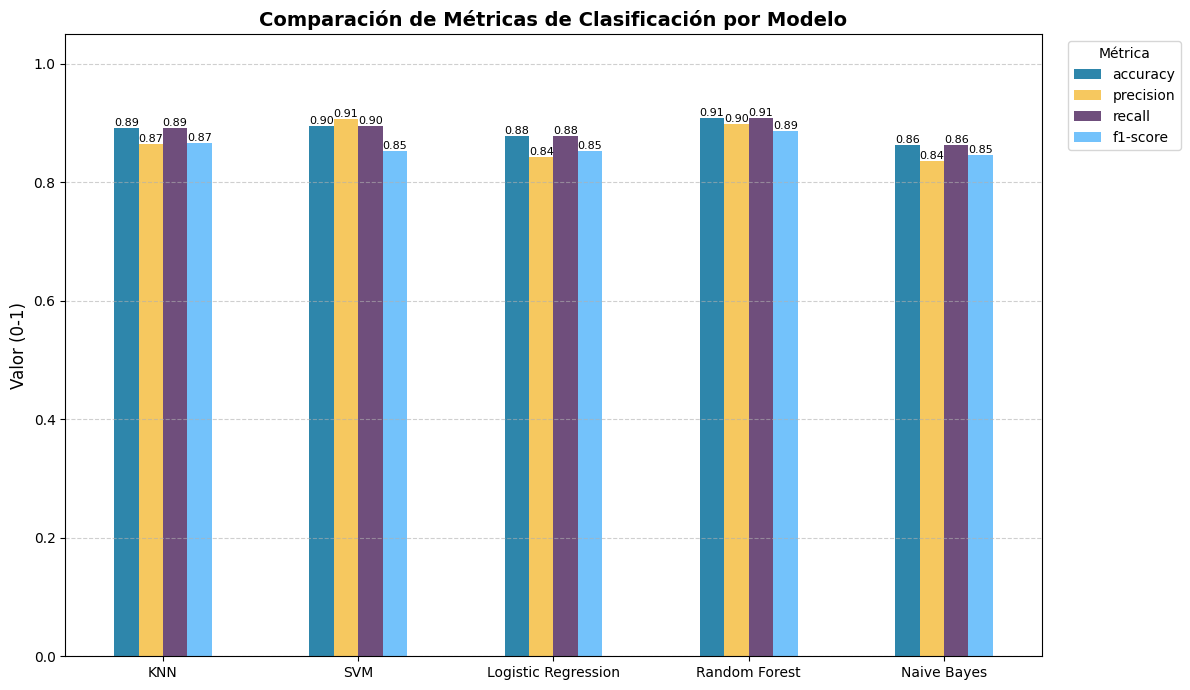

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

metricas = ['accuracy', 'precision', 'recall', 'f1-score']
metricas_resultado = {metrica: [] for metrica in metricas}
modelos_nombres = []

for nombre, resultado in resultados.items():
    modelos_nombres.append(nombre)
    reporte = resultado['reporte']
    metricas_resultado['accuracy'].append(resultado['accuracy'])
    metricas_resultado['precision'].append(reporte['weighted avg']['precision'])
    metricas_resultado['recall'].append(reporte['weighted avg']['recall'])
    metricas_resultado['f1-score'].append(reporte['weighted avg']['f1-score'])

df_metricas = pd.DataFrame(metricas_resultado, index=modelos_nombres)

# Elegante paleta profesional
colores_elegantes = ['#2E86AB', '#F6C85F', '#6F4E7C', '#73C2FB']

plt.figure(figsize=(12, 7))
bar_plot = df_metricas.plot(kind='bar', figsize=(12, 7), color=colores_elegantes)

for p in bar_plot.patches:
    height = p.get_height()
    if height > 0:
        bar_plot.annotate(f'{height:.2f}',
                          (p.get_x() + p.get_width() / 2., height),
                          ha='center', va='bottom', fontsize=8, color='black')

plt.title("Comparación de Métricas de Clasificación por Modelo", fontsize=14, weight='bold')
plt.ylabel("Valor (0-1)", fontsize=12)
plt.ylim(0, 1.05)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Métrica', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

### PARTE C – Optimización de Hiperparámetros

c.2 – Aplicar GridSearchCV y RandomizedSearchCV al mejor modelo (Random Forest)

In [105]:
# c.2 - Definir parámetros para búsqueda con GridSearch y RandomSearch para Random Forest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Definimos el modelo base
rf_model = RandomForestClassifier(random_state=42)

# Definimos el espacio de búsqueda
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

c.3 – Ejecutar GridSearchCV

In [106]:
# Búsqueda en cuadrícula (más exhaustiva)
grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

c.4 – Ejecutar RandomizedSearchCV

In [107]:
# Búsqueda aleatoria (más rápida)
random_search = RandomizedSearchCV(estimator=rf_model,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   scoring='accuracy',
                                   cv=5,
                                   n_jobs=-1,
                                   random_state=42)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 5, 10, 20],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='accuracy')

c.5 – Mostrar los mejores resultados

In [108]:
print(" Mejor resultado con GridSearchCV:")
print("Accuracy:", grid_search.best_score_)
print("Mejores hiperparámetros:", grid_search.best_params_)

print("\n Mejor resultado con RandomizedSearchCV:")
print("Accuracy:", random_search.best_score_)
print("Mejores hiperparámetros:", random_search.best_params_)


 Mejor resultado con GridSearchCV:
Accuracy: 0.9027977748691101
Mejores hiperparámetros: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}

 Mejor resultado con RandomizedSearchCV:
Accuracy: 0.9027977748691101
Mejores hiperparámetros: {'n_estimators': 50, 'min_samples_split': 5, 'max_depth': 20}


c.6 – Evaluar el mejor modelo optimizado en el conjunto de prueba

In [109]:
# Evaluar el mejor modelo del GridSearch sobre test
best_rf_model = grid_search.best_estimator_
y_pred_best = best_rf_model.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score

print(" Evaluación final del modelo optimizado (GridSearch) en test:")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))


 Evaluación final del modelo optimizado (GridSearch) en test:
Accuracy: 0.9125
              precision    recall  f1-score   support

           0       0.80      0.30      0.43        27
           1       0.92      0.99      0.95       213

    accuracy                           0.91       240
   macro avg       0.86      0.64      0.69       240
weighted avg       0.90      0.91      0.89       240



In [110]:
# Crear resumen de métricas de modelos base
resumen_c1 = []

for nombre, resultado in resultados.items():
    reporte = resultado['reporte']
    resumen_c1.append({
        'Modelo': nombre,
        'Accuracy': round(resultado['accuracy'], 4),
        'Precision': round(reporte['weighted avg']['precision'], 4),
        'Recall': round(reporte['weighted avg']['recall'], 4),
        'F1-Score': round(reporte['weighted avg']['f1-score'], 4)
    })

# Convertir a DataFrame
df_resumen_c1 = pd.DataFrame(resumen_c1)

# Mostrar como tabla
print("\n Comparación de métricas para modelos con hiperparámetros estándar (C.1):")
display(df_resumen_c1)



 Comparación de métricas para modelos con hiperparámetros estándar (C.1):


,Modelo,Accuracy,Precision,Recall,F1-Score
0,KNN,0.8917,0.8655,0.8917,0.8668
1,SVM,0.8958,0.9068,0.8958,0.8538
2,Logistic Regression,0.8792,0.8438,0.8792,0.8537
3,Random Forest,0.9083,0.8982,0.9083,0.8873
4,Naive Bayes,0.8625,0.8355,0.8625,0.8466


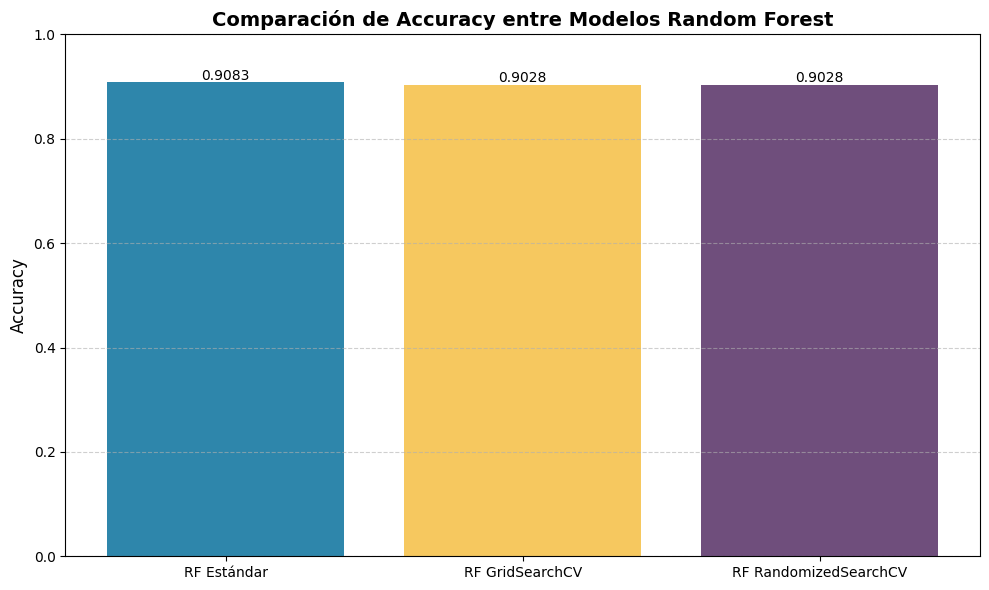

In [114]:
import matplotlib.pyplot as plt

# Definir accuracies nuevamente
accuracy_estandar = resultados['Random Forest']['accuracy']
accuracy_grid = grid_search.best_score_
accuracy_random = random_search.best_score_

# Diccionario de comparación
comparacion_accuracy = {
    'RF Estándar': accuracy_estandar,
    'RF GridSearchCV': accuracy_grid,
    'RF RandomizedSearchCV': accuracy_random
}

# Colores compatibles con el otro gráfico
colores_compatibles = ['#2E86AB', '#F6C85F', '#6F4E7C']  # Azul, dorado, púrpura

# Dibujar el gráfico
plt.figure(figsize=(10, 6))
bars = plt.bar(comparacion_accuracy.keys(), comparacion_accuracy.values(), color=colores_compatibles)

# Etiquetas sobre cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., yval + 0.005, f'{yval:.4f}', ha='center', fontsize=10)

# Estética
plt.title("Comparación de Accuracy entre Modelos Random Forest", fontsize=14, fontweight='bold')
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0.00, 1.00)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()